In [42]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from pygam import LinearGAM, s, l
from pygam.datasets import wage
import seaborn as sns
import matplotlib.pyplot as plt
from dmba import stepwise_selection
from dmba import AIC_score
sns.set_style("whitegrid")

In [43]:
from sklearn.datasets import fetch_california_housing
df = fetch_california_housing(as_frame=True,return_X_y=True)

In [44]:
X,y = df
X['target'] = y

In [45]:
# Correlation measures strength -> Regression quantifies natures of the relationship
predictors =['MedInc']
model = LinearRegression()
model.fit(X[predictors], y)

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 0.451
Coefficient Exposure: 0.418


In [46]:
# fitted -> predictions
# residuals -> residuals = real - predicted
# Estimated minimizing RSS
sample_ = X.sample(20)
fitted = model.predict(sample_[predictors])
residuals = sample_['target'] - fitted

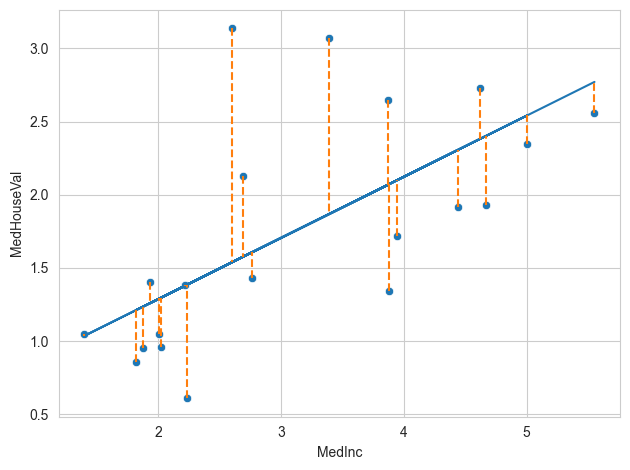

In [47]:
ax = sns.scatterplot(x=sample_['MedInc'],y=y)
ax.plot(sample_['MedInc'], fitted)
for x, yactual, yfitted in zip(sample_['MedInc'], sample_['target'], fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

In [48]:
# Predicition x Explaining -> 
# Understand a relationship between variable and data
# Widely used in data science for predictions
# By itself, it does not prove causation -> Must come from a understading of the problem in hand.


In [49]:
# Multiple linear regression
predictors = [x for x in X.columns if x!='target']
outcome = 'target'
house_lm = LinearRegression()
house_lm.fit(X[predictors],X[outcome])

LinearRegression()

In [50]:
print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
 print(f' {name}: {coef}')

Intercept: -36.942
Coefficients:
 MedInc: 0.43669329313432437
 HouseAge: 0.00943577803323789
 AveRooms: -0.10732204139090415
 AveBedrms: 0.6450656935198097
 Population: -3.9763894212480055e-06
 AveOccup: -0.0037865426549708904
 Latitude: -0.4213143775271446
 Longitude: -0.4345137546747788


In [51]:
# Assessing model
# RMSE -> Root of averaged error
# RSE -> Takes in account number of parameters (variables)
fitted = house_lm.predict(X[predictors])
RMSE = np.sqrt(mean_squared_error(X[outcome], fitted))
r2 = r2_score(X[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')
# R^2 -> measures the proportion of variation in the data that is accounted for in the model. -> between [0,1] 

RMSE: 1
r2: 0.6062


In [52]:
model = sm.OLS(X[outcome], X[predictors].assign(const=1)) # assign to add intercept to the model.
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:16:52   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MedInc         0.4367      0.004    104.054      0.000       0.428       0.445
HouseAge       0.0094      0.000     21.143      0.000       0.009       0.010
AveRooms      -0.1073      0.006    -18.235      0.000      -0.119      -0.096
AveBedrms      0.6451      0.028     22.928      0.000       0.590       0.700
Population -3.976e-06   4.75e-06     -0.837      0.402   -1.33e-05    5.33e-06
AveOccup      -0.0038      0.000     -7.769      0.000      -0.005      -0.003
Latitude      -0.4213      0.007    -58.541      0.000      -0.435      -0.407
Longitude     -0.4345      0.008    -57.682      0.000      -0.449      -0.420
const        -36.9419      0.659    -56.067      0.000     -38.233     -35.650
==============================================================================
Omnibus:                     4393.650   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14087.596
Skew:                           1.082   Prob(JB):                         0.00
Kurtosis:                       6.420   Cond. No.                     2.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
# SE of coefficients
# p-values on coefficients -> The lower the p-value, the more signifcant the feature.

In [54]:
# Cross-validation -> Divides data in 5 folds (4 for training and 1 for test). Record eval score and repeat it for 5 iters.

In [55]:
# Model selection
# Adding more variables dont imply in better model
# Occam's razor -> If two hypothesis are similar, pick the one with less variables.
# AIC = 2P + n log(RSS/n)the model that minimizes AIC; models with k more extra variables are penalized by 2P

In [56]:
# Stepwise regression -> Starts with model with noo variable, goes on adding and checks if the model improves.

y = X[outcome]
def train_model(variables):
 if len(variables) == 0:
    return None
 model = LinearRegression()
 model.fit(X[variables], y)
 return model
def score_model(model, variables):
 if len(variables) == 0:
    return AIC_score(y, [y.mean()] * len(y), model, df=1)
 return AIC_score(y, model.predict(X[variables]), model)
best_model, best_variables = stepwise_selection([x for x in X.columns if x != 'target'], train_model,
 score_model, verbose=True)
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
 print(f' {name}: {coef}')

Variables: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude
Start: score=64487.92, constant
Step: score=51251.34, add MedInc
Step: score=49805.43, add HouseAge
Step: score=49465.16, add Latitude


Step: score=45889.71, add Longitude
Step: score=45645.58, add AveBedrms
Step: score=45325.98, add AveRooms
Step: score=45266.24, add AveOccup
Step: score=45266.24, unchanged None
Intercept: -36.918
Coefficients:
 MedInc: 0.43675974780362387
 HouseAge: 0.009555467799549779
 Latitude: -0.4206994165555515
 Longitude: -0.43404215355951764
 AveBedrms: 0.6449021952418102
 AveRooms: -0.1071340577906914
 AveOccup: -0.003819327912849145


In [57]:
# Prediction using regression
# Primary focus in data science -> Prediction
# Statistics -> Explaining data
# Should not be used to extrapolate data

In [58]:
# Confidence/Prediction intervals 
# Most common regression confidence intervals are for parameters
# Bootstrap algorithm to generate confidence intervals.
# 1. Bootstrap (with replacement) sample of the data
# 2. Fit a regression and store the coeficients
# 3. Repeat this process k times
# In data science, the focus is on the prediction
# # Uncertainty around prediction come from two sources:
# 1. Uncertainty arround what the relevant predictors and coefficients are
# 2. Additional error inherent to data points
# Modeling both regression error/individual data points
#1. Bootstrap sample of the data -> Fit and predict
#2. Take a single residual at random from the original regression fit, add it to the predicted value, record the result
#3. Repeat the process K times
# Find the 2.5th and 97.5th percentile (95%) 
# See conformal prediction!!

In [59]:
# Factor Variables in Regression
# Dummy variables -> One hot encoding
# Reference encoding -> Encodes n-1 categories in the column, the one that wasnt encoded is the reference level (drop_first)
# Adding column for every category can lead to multicollinearity
# Example (Zipcode) -> Can have large cardinality (70+ in the github example)
# Fit a regression without using the other predictors
# Get the residual for each instance
# Groupby zip code and get the median residual and sort by the median residual
# Group the zip codes in k(for example 5) groups (20,40,60,80,100 percentiles) and construct a new category with it.

# Ordered categorical variables -> Low,Medium,High

In [60]:
# Interpreting regression equation
# Correlated variables -> When the predictor variables are highly correlated, its difficult to interpret individual coefficients
# Multicollinearity -> One variable can be expressed as a linear combination of the others (VIF to spot this) -> Not a big deal in non linear regression, like trees, clustering,nn
# Cofounding variable -> Important variable that, when ommited, can lead to spurious correlations
# Interactions and main effects -> Interactions between predictor variables
# Prior knowlodge can guide the interactions terms.
model = smf.ols(formula='target ~ MedInc + HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude + MedInc*HouseAge', data=X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     3549.
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:16:52   Log-Likelihood:                -22589.
No. Observations:               20640   AIC:                         4.520e+04
Df Residuals:                   20630   BIC:                         4.528e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -37.1294      0.658    -

In [61]:
# Regression Diagnostics
# Do not address specifically predictive accuracy, but can help
# Outliers -> No formal definition, but a lot of rules of thumb 

In [62]:
model = sm.OLS(X[outcome], X[predictors].assign(const=1)) # assign to add intercept to the model.
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:16:52   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MedInc         0.4367      0.004    104.054      0.000       0.428       0.445
HouseAge       0.0094      0.000     21.143      0.000       0.009       0.010
AveRooms      -0.1073      0.006    -18.235      0.000      -0.119      -0.096
AveBedrms      0.6451      0.028     22.928      0.000       0.590       0.700
Population -3.976e-06   4.75e-06     -0.837      0.402   -1.33e-05    5.33e-06
AveOccup      -0.0038      0.000     -7.769      0.000      -0.005      -0.003
Latitude      -0.4213      0.007    -58.541      0.000      -0.435      -0.407
Longitude     -0.4345      0.008    -57.682      0.000      -0.449      -0.420
const        -36.9419      0.659    -56.067      0.000     -38.233     -35.650
==============================================================================
Omnibus:                     4393.650   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14087.596
Skew:                           1.082   Prob(JB):                         0.00
Kurtosis:                       6.420   Cond. No.                     2.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
influence = OLSInfluence(results)
sresiduals = influence.resid_studentized_internal
sresiduals.idxmin(), sresiduals.min()

(1979, -11.86012302553544)

In [64]:
outlier = X.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 1.625
MedInc          4.625000
HouseAge       34.000000
AveRooms      132.533333
AveBedrms      34.066667
Population     36.000000
AveOccup        2.400000
Latitude       38.800000
Longitude    -120.080000
Name: 1979, dtype: float64


In [65]:
# Influential values -> Can change the regression equation
# Cook distance -> Metric to check if is influential 
# For large data few data points wont matter that much, but for small data can hurt generalization

Text(0, 0.5, 'studentized residuals')

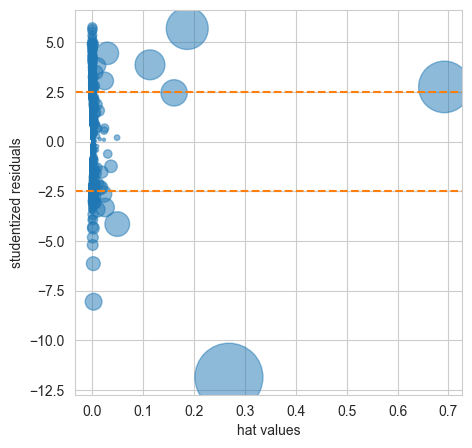

In [66]:
influence = OLSInfluence(results)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
 s=1000 * np.sqrt(influence.cooks_distance[0]),
 alpha=0.5)
ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

In [67]:
mask = [dist < .02 for dist in influence.cooks_distance[0]]
house_infl = X.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': results.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
MedInc,0.436693,0.450356
HouseAge,0.009436,0.009891
AveRooms,-0.107322,-0.130902
AveBedrms,0.645066,0.814009
Population,-0.000004,0.000006
AveOccup,-0.003787,-0.048463
Latitude,-0.421314,-0.415235
Longitude,-0.434514,-0.427332
const,-36.941920,-36.303948


In [68]:
# Heteroskedasticity, Non-Normality, and Correlated Errors
# Normality in residuals -> Model is complete
# Heteroskedasticity -> Lack of constant residual variance in predicted values
# Errors should be independent
# Satisfying all assumptions is not that important for data scientist, 'cause its more focused on prediction
"""fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=results.fittedvalues, y=np.abs(results.resid),
 scatter_kws={'alpha': 0.25}, line_kws={'color': 'C1'},
 lowess=True, ax=ax)"""


"fig, ax = plt.subplots(figsize=(5, 5))\nsns.regplot(x=results.fittedvalues, y=np.abs(results.resid),\n scatter_kws={'alpha': 0.25}, line_kws={'color': 'C1'},\n lowess=True, ax=ax)"

In [69]:
# Partial Residual Plots and Nonlinearity -> Isolate relantionship between predicted variable and response

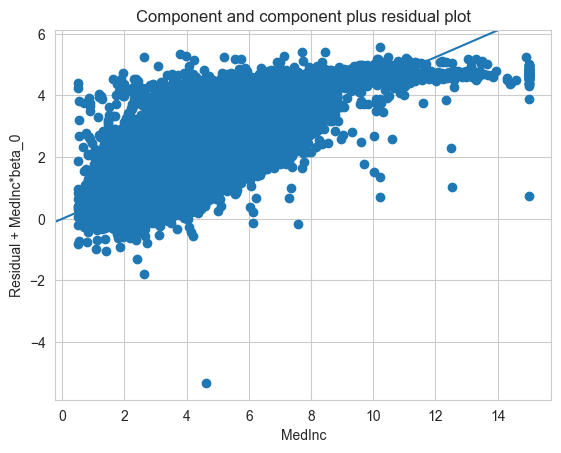

In [70]:
# Might be non linear?
_ = sm.graphics.plot_ccpr(results, 'MedInc')

In [71]:
# Polynomial and Spline Regression
model_poly = smf.ols(formula='target ~ I(MedInc**2) + HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude + MedInc*HouseAge', data=X)
result_poly = model_poly.fit()
result_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     3263.
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:16:55   Log-Likelihood:                -22454.
No. Observations:               20640   AIC:                         4.493e+04
Df Residuals:                   20629   BIC:                         4.502e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -35.5339      0.661    -53.751      0.000     -36.830     -34.238
I(MedInc ** 2)     -0.0116      0.001    -16.447      0.000      -0.013      -0.010
HouseAge            0.0027      0.001      3.001      0.003       0.001       0.005
AveRooms           -0.1246      0.006    -20.711      0.000      -0.136      -0.113
AveBedrms           0.7222      0.029     25.197      0.000       0.666       0.778
Population      -4.152e-06   4.72e-06     -0.880      0.379   -1.34e-05     5.1e-06
AveOccup           -0.0038      0.000     -7.925      0.000      -0.005      -0.003
Latitude           -0.4033      0.007    -55.249      0.000      -0.418      -0.389
Longitude          -0.4165      0.008    -54.652      0.000      -0.431      -0.402
MedInc              0.5184      0.011     47.211      0.000       0.497       0.540
MedInc:HouseAge     0.0019      0.000      9.522      0.000       0.002       0.002
==============================================================================
Omnibus:                     4469.025   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15279.839
Skew:                           1.079   Prob(JB):                         0.00
Kurtosis:                       6.621   Cond. No.                     2.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

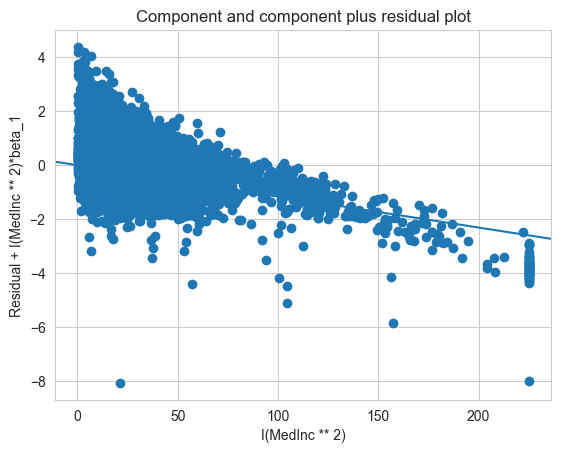

In [72]:
# Might be non linear?
_ = sm.graphics.plot_ccpr(result_poly, 'I(MedInc ** 2)')

In [73]:
# Splines
# Polynomials can lead to undesirable "wigleness" in the regression equation.
# Splines -> Better alternative. Smoothly interpolate between various points
# Spline -> Series of piecewise continuous functions. 
# Knots -> Series of fixed points in a predictor variable

# Creates df - degree internal knots in pct (0.25,0.5,0.7) perncetiles  
model_spline = smf.ols(formula='target ~ bs(MedInc,df=6,degree=3) + HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude + MedInc*HouseAge', data=X)
result_spline = model_spline.fit()
result_spline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     2479.
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:16:55   Log-Likelihood:                -22059.
No. Observations:               20640   AIC:                         4.415e+04
Df Residuals:                   20625   BIC:                         4.427e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -34.2081      0.662    -51.669      0.000     -35.506     -32.910
bs(MedInc, df=6, degree=3)[0]    -1.0037      0.124     -8.119      0.000      -1.246      -0.761
bs(MedInc, df=6, degree=3)[1]    -0.5155      0.069     -7.454      0.000      -0.651      -0.380
bs(MedInc, df=6, degree=3)[2]    -0.3855      0.068     -5.699      0.000      -0.518      -0.253
bs(MedInc, df=6, degree=3)[3]     0.6296      0.062     10.125      0.000       0.508       0.751
bs(MedInc, df=6, degree=3)[4]     2.4002      0.102     23.588      0.000       2.201       2.600
bs(MedInc, df=6, degree=3)[5]    -0.7674      0.076    -10.053      0.000      -0.917      -0.618
HouseAge                         -0.0020      0.001     -2.142      0.032      -0.004      -0.000
AveRooms                         -0.1255      0.006    -21.216      0.000      -0.137      -0.114
AveBedrms                         0.7238      0.028     25.673      0.000       0.669       0.779
Population                     2.562e-06   4.64e-06      0.552      0.581   -6.53e-06    1.17e-05
AveOccup                         -0.0042      0.000     -8.862      0.000      -0.005      -0.003
Latitude                         -0.4044      0.007    -56.295      0.000      -0.418      -0.390
Longitude                        -0.4172      0.007    -55.640      0.000      -0.432      -0.402
MedInc                            0.1723      0.012     14.902      0.000       0.150       0.195
MedInc:HouseAge                   0.0032      0.000     15.841      0.000       0.003       0.004
==============================================================================
Omnibus:                     4863.231   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17769.957
Skew:                           1.152   Prob(JB):                         0.00
Kurtosis:                       6.919   Cond. No.                     1.55e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.86e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [96]:
predictors

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [113]:
# Generalized Additive Models -> Can be used to automatically fit a spline regression
predictors = [x for x in X.columns if x != 'target']
outcome = 'target'
from statsmodels.gam.api import GLMGam, BSplines
x_spline = X[predictors]
bs = BSplines(x_spline, df=[10] + [3] * 8, degree=[3] + [2] * 8)
formula = ('target ~ MedInc + ' + 'HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude')
# penalization weight
alpha = np.array([0] * 8)
gam_sm = GLMGam.from_formula(formula, data=X, smoother=bs, alpha=alpha)
res_sm = gam_sm.fit()
print(res_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                20640
Model:                         GLMGam   Df Residuals:                    20616
Model Family:                Gaussian   Df Model:                        23.00
Link Function:               Identity   Scale:                         0.48602
Method:                         PIRLS   Log-Likelihood:                -21829.
Date:                Sat, 02 Dec 2023   Deviance:                       10020.
Time:                        12:25:49   Pearson chi2:                 1.00e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8246
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2606      0.005    -49.019

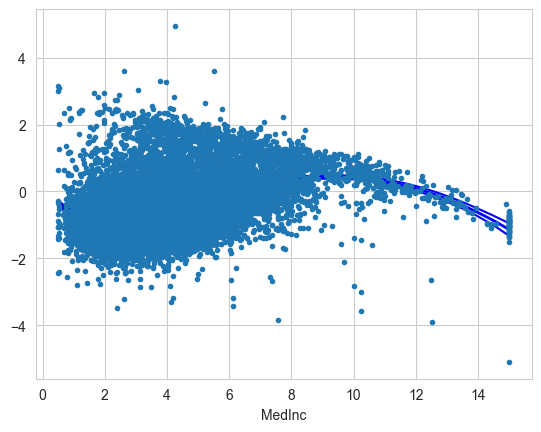

In [114]:
res_sm.plot_partial(0, cpr=True);

In [116]:
Xc = X[predictors].values
y = X[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7))
gam.gridsearch(Xc, y) 
print(gam.summary())

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:03
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.0076
Link Function:                     IdentityLink Log Likelihood:                                -25282.3685
Number of Samples:                        20640 AIC:                                            50602.7522
                                                AICc:                                           50602.7891
                                                GCV:                                                0.5015
                                                Scale:                                              0.5007
                                                Pseudo R-Squared:                                   0.6243
Feature Function                  Lam

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_11456\302928909.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


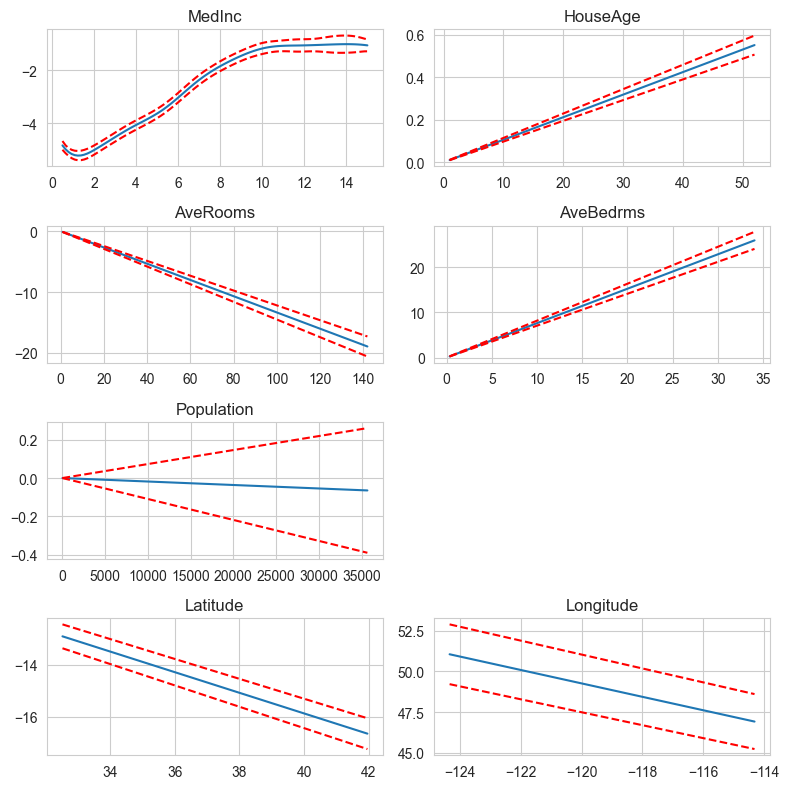

In [119]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=4)

titles = predictors
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

In [127]:
## Regularization

from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
y = X[outcome]
Xs = StandardScaler().fit_transform(X[predictors])
house_lm = LinearRegression()
print(house_lm.fit(Xs, y))

LinearRegression()


In [128]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(Xs, y))

Lasso(alpha=10)


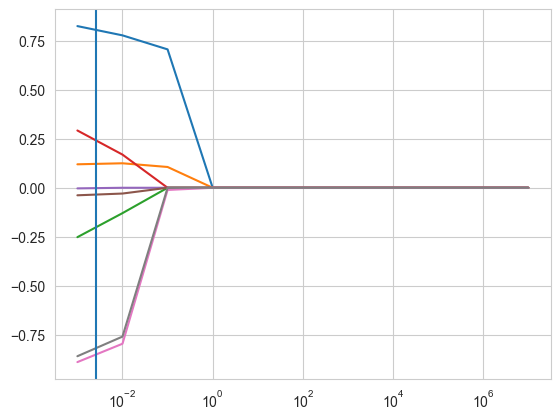

In [129]:
Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(Xs, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(Xs, y)
ax = pd.DataFrame(results, index=alpha_values, columns=predictors).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [130]:
pd.DataFrame({
    'name': predictors,
    'coef': modelCV.coef_, 
})

,name,coef
0,MedInc,0.816164
1,HouseAge,0.121141
2,AveRooms,-0.230080
3,AveBedrms,0.270293
4,Population,-0.000990
5,AveOccup,-0.036938
6,Latitude,-0.871817
7,Longitude,-0.840841
